In [1]:
import os
import sys
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import shutil
import dill

sys.path.insert(0, os.path.join("..", "..", ".."))

from petroflow import Well, WellBatch, WS, WellDataset
from petroflow.batchflow.models.torch import ResUNet, UNet
from petroflow.batchflow import Dataset, DatasetIndex, FilesIndex, Batch, Pipeline, M, V, B, action, inbatch_parallel, I, W, F, L, ImagesBatch, R, P

In [2]:
BATCH_SIZE = 16
N_CROPS = 4

CROPS_BATCH = BATCH_SIZE * N_CROPS

N_EPOCH = 500
LENGTH = 0.1
SHAPE = (3, int(2500 * LENGTH), 250)

Remove wells without `core_lithology`

In [3]:
index = FilesIndex(path='/notebooks/data/september_dataset/core_photo/*/*', dirs=True)
ds = WellDataset(index=index)

filter_ppl = (ds.p
              .init_variable('wells', default=[])
              .has_attr('core_lithology')
              .update(V('wells', mode='e'), B().indices)
              .run(10, n_epochs=1, shuffle=False, bar=True))

filtered_index = index.create_subset(filter_ppl.v('wells'))
ds = WellDataset(index=filtered_index)
ds.split()

 88%|████████▊ | 30/34 [00:00<00:00, 94.40it/s]


Get list of classes

In [4]:
def concat(df):
    return df.FORMATION + ' ' + df.GRAIN

classes_ppl = (ds.p
       .init_variable('classes', default=[])
       .update(V('classes', mode='a'), (
           WS('core_lithology')[['FORMATION', 'GRAIN']].apply(concat, axis=1).values.ravel()))
)

(classes_ppl.after
    .add_namespace(np)
    .concatenate(L(sum)(V('classes'), []), save_to=V('classes', mode='w'))
    .unique(V('classes'), save_to=V('classes'))
)

classes_ppl.run(BATCH_SIZE)

Construct mapping from classes to labels

In [5]:
reverse_mapping = dict(enumerate(classes_ppl.v('classes')))
mapping = {value: key for key, value in reverse_mapping.items()}

Preloaded

In [6]:
def build_dataset(batch):
    preloaded = ({k: v for k, v in zip(batch.indices, batch.wells)},)
    ds = WellDataset(index=batch.index, preloaded=preloaded, copy=False)
    return ds

In [7]:
%%time

ds = build_dataset(
    ds.p
    .create_segments(src='samples', connected=True)
    .create_segments(src='core_lithology', connected=True)
    .drop_short_segments(LENGTH)
    .load_core(pixels_per_cm=25)
    #.next_batch(len(ds), n_epochs=1)
    .next_batch(8, n_epochs=1)
)

CPU times: user 16 s, sys: 2.51 s, total: 18.5 s
Wall time: 5.24 s


In [8]:
ds.split(shuffle=42)

Start the straining on random crops

In [9]:
crop_template = (Pipeline()
       .add_namespace(np)
       .copy()
       .random_crop(length=LENGTH, n_crops=N_CROPS)
       .update(WS('core_lithology')['CLASS'], WS('core_lithology')[['FORMATION', 'GRAIN']].apply(concat, axis=1).ravel())
       .create_mask(src='core_lithology', column='CLASS', mapping=mapping, mode='core')
       .update(B('core'), WS('core_dl').ravel())
       .update(B('masks'), WS('mask').ravel())
       .array(B('core'), save_to=B('core'))
       .array(B('masks'), save_to=B('masks'))
       .reshape(B('masks'), (-1, 1, 250), save_to=B('masks'))
)

In [10]:
augmentation_template = (
    Pipeline()
    .update(B().index, L(DatasetIndex)(L(len)(B('core'))))
    .rebatch(CROPS_BATCH, batch_class=ImagesBatch, components=('core', 'masks'))
    .add_namespace(np)
    .to_pil(src='core', dst='core')
    .scale(src='core', dst='core', preserve_shape=True, factor=P(R('uniform', low=1, high=1.5)))
    .cutout(shape=P(R('randint', low=[200, 0], high=[250, 40])),
            origin=P(R('uniform', size=2)), color=0,
            src='core', dst='core', p=0.5)
    .multiply(src='core', dst='core', multiplier=P(R('uniform', low=0.7, high=1.2)))
    .to_array(src='core', dst='core', dtype='float32')
    .transpose(B('core'), axes=(0, 3, 1, 2), save_to=B('core'))
)

In [11]:
# def add_lithology_position(well, segment=0):
#     segment = well.iter_level()[segment]
#     core_lithology = segment.core_lithology
#     image = segment.core_dl
#     factor = image.shape[0] / segment.length
#     positions = []
#     for (depth_from, depth_to), formation in core_lithology.iterrows():
#         positions.append(
#             (max(0, depth_from - segment.depth_from) * factor,
#              min(segment.length, depth_to - segment.depth_from) * factor)
#         )
#     return positions

In [12]:
# for well in batch.wells:
#     for i, segment in enumerate(well.iter_level()):
#         if len(segment.core_lithology) > 1:
#             plt.figure(figsize=(4, 20))
#             print(segment.core_lithology)
#             img = segment.core_dl / 255
#             mask = segment.mask
#             lithology = segment.core_lithology
#             plt.imshow(img)
#             for a, b in add_lithology_position(well, segment=i):
#                 plt.hlines(a, 0, img.shape[1], colors='r')
#                 plt.hlines(b, 0, img.shape[1], colors='r')
#             plt.show()
#             break

In [13]:
filters = ((2 ** np.arange(4)) * 4).tolist()

model_config = {
    "body/encoder/num_stages": len(filters[:-1]),
    'body/encoder/blocks/filters': filters[:-1],
    "body/decoder/blocks/filters": filters[-2::-1],
    "initial_block/inputs": "inputs",
    "inputs/inputs/shape": SHAPE,
    'inputs/masks/shape': (len(mapping), 1, SHAPE[1]),
    "head": dict(layout="c",
                 kernel_size=(SHAPE[2], 1), padding='valid'),#, conv=dict(bias=True)),
    "loss": "ce",
    "optimizer": {"name": "Adam", "lr": 0.01},
    "output": 'proba',
    'device': 'gpu:1',
}
        
train_template = (Pipeline()
    .init_variable('loss_history', default=[])
    .init_model('dynamic', UNet, 'model', model_config)
    .train_model('model', B('core').astype('float32'),
                 B('masks'), fetches='loss',
                 save_to=V('loss_history', mode='a'))
)

train_ppl = (crop_template + augmentation_template + train_template) << ds.train

In [14]:
train_ppl.next_batch(1, n_epochs=N_EPOCH, bar=True, bar_desc=W(V('loss_history')[-1]))

train_ppl.get_model_by_name('model').save('unet.torch')

with open('loss.pkl', 'wb') as f:
    dill.dump(train_ppl.v('loss_history'), f)

  0%|          | 0/3000 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3509: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

3.0035264:   0%|          | 1/3000 [00:12<10:31:43, 12.64s/it]/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning:

Couldn't retrieve source code for container of type DefaultBlock. It won't be checked for correctness upon loading.

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning:

Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning:

Couldn't retrieve source code for container of type EncoderModule. I

In [15]:
with open('loss.pkl', 'rb') as f:
    loss = dill.load(f)

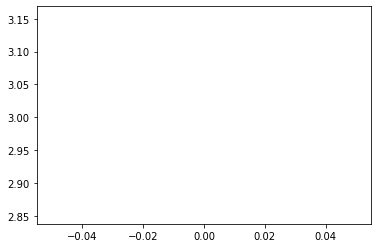

In [16]:
import pandas as pd
plt.plot(loss)
plt.plot(pd.Series(loss).rolling(window=100).mean())

In [17]:
def test_template(length, random_crop=False, step=None, n_crops=None):
    step = step or length
    n_crops = n_crops or 4

    if random_crop:
        ppl = Pipeline().random_crop(length=length, n_crops=n_crops)
    else:
        ppl = Pipeline().crop(length=length, step=step)

    ppl = ppl + (Pipeline()
        .add_namespace(np)
        .copy()
        .add_components(('core', 'masks'))
        .update(WS('core_lithology')['CLASS'], WS('core_lithology')[['FORMATION', 'GRAIN']].apply(concat, axis=1).ravel())
        .create_mask(src='core_lithology', column='CLASS', mapping=mapping, mode='core').update(B('core'), WS('core_dl').ravel())
        .update(B('masks'), WS('mask').ravel())
        .array(B('core'), save_to=B('core'))
        .array(B('masks'), save_to=B('masks'))
        .transpose(B('core'), axes=(0, 3, 1, 2), save_to=B('core'))
        .reshape(B('masks'), (-1, 1, 250), save_to=B('masks'))
        .update(B().index, L(DatasetIndex)(B('core').shape[0]))
        .rebatch(32, components=('core', 'masks'), batch_class=ImagesBatch)
        .init_variable('metrics')
        .add_namespace(np)
        .init_model('dynamic', UNet, 'model', config={
                        'device': 'gpu:1', 'load/path': 'unet.torch'
                    })
        .predict_model('model', B('core').astype('float32'), fetches='proba', save_to=B('proba'))
        .gather_metrics('classification', targets=B('masks').reshape(-1),
                        predictions=B('proba').argmax(1).reshape(-1),
                        fmt='labels', num_classes=len(mapping), save_to=V('metrics', mode='u'))
    )
    return ppl

test_ppl = test_template(LENGTH, random_crop=False) << ds.test

In [18]:
test_ppl.run(1, bar=True)

metrics = test_ppl.v('metrics')

with open('metrics.pkl', 'wb') as f:
    dill.dump(test_ppl.v('metrics'), f)


100%|██████████| 2/2 [00:08<00:00,  5.71s/it]
3it [00:08,  4.12s/it]                       
4it [00:09,  3.00s/it]
5it [00:09,  2.21s/it]
6it [00:09,  1.66s/it]
7it [00:10,  1.26s/it]
8it [00:10,  1.02it/s]
9it [00:10,  1.29it/s]
10it [00:11,  1.60it/s]
11it [00:11,  1.92it/s]
12it [00:11,  2.25it/s]
13it [00:11,  2.61it/s]
14it [00:12,  2.97it/s]
15it [00:12,  3.30it/s]
16it [00:12,  3.62it/s]
17it [00:12,  3.97it/s]
18it [00:12,  4.30it/s]
19it [00:13,  4.65it/s]
20it [00:13,  4.93it/s]
21it [00:13,  5.38it/s]
22it [00:13,  5.99it/s]
23it [00:13,  6.58it/s]
24it [00:13,  7.15it/s]
26it [00:17,  1.49it/s]
27it [00:17,  1.80it/s]
28it [00:18,  2.16it/s]
29it [00:18,  2.51it/s]
30it [00:18,  2.89it/s]
31it [00:18,  3.26it/s]
32it [00:19,  3.63it/s]
33it [00:19,  4.02it/s]
34it [00:19,  4.39it/s]
35it [00:19,  4.78it/s]
36it [00:19,  5.19it/s]
37it [00:19,  5.82it/s]
38it [00:19,  6.46it/s]
39it [00:20,  7.17it/s]
41it [00:21,  1.94it/s]


In [19]:
with open('metrics.pkl', 'rb') as f:
    metrics = dill.load(f)

In [20]:
metrics._confusion_matrix.sum()

327250

In [21]:
for i, item in enumerate(metrics.evaluate('f1_score', agg='mean', multiclass=None)):
    print(reverse_mapping[i], item)

алевролит UNKNOWN inf
алевролит крупно-мелкозернистый 0.0
алевролит крупнозернистый 0.007856916282360979
алевролит мелкозернистый inf
алевролит разнозернистый 0.04078746393618827
аргиллит UNKNOWN 0.15590776950340487
глина UNKNOWN 0.0
доломит UNKNOWN 0.0
известняк UNKNOWN 1.0
песчаник UNKNOWN 0.0021312559711912983
песчаник крупнозернистый inf
песчаник мелкозернистый 0.0015399194503672117
песчаник разнозернистый 0.0
песчаник средне-мелкозернистый 0.041430404370680025
песчаник среднезернистый 0.0
песчаник тонко-мелкозернистый 0.0001622586402725945
песчаник тонкозернистый 9.79479896175131e-05
уголь UNKNOWN 0.0


../../../petroflow/batchflow/batchflow/models/metrics/classify.py:343: RuntimeWarning:

invalid value encountered in true_divide



In [22]:
batch = (test_template(LENGTH, random_crop=True) << ds.test).next_batch(1)

images = np.transpose(batch.core, axes=(0, 2, 3, 1))
predictions = np.tile(batch.proba.argmax(1), (1, 250, 1)).transpose(0, 2, 1)
targets = np.tile(batch.masks, (1, 250, 1)).transpose(0, 2, 1)

In [23]:
from matplotlib import colors

cmap = colors.ListedColormap(
    ['green'] * 5 + ['blue', 'grey', 'yellow', 'w'] + ['orange'] * 8 + ['black']
)

bounds = np.arange(-0.5, len(mapping) + 0.5, 1)
norm = colors.BoundaryNorm(bounds, cmap.N)

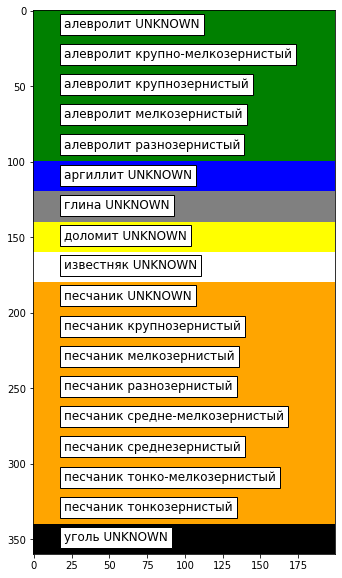

In [24]:
a = np.ones((20, 200))
b = np.concatenate([i * a for i in range(len(mapping))], axis=0)
plt.figure(figsize=(15, 10))
plt.imshow(b, norm=norm, cmap=cmap)
for i, value in reverse_mapping.items():
    plt.text(20, 20 * i + 11, value, color='black', fontsize=12, bbox=dict(facecolor='white'))

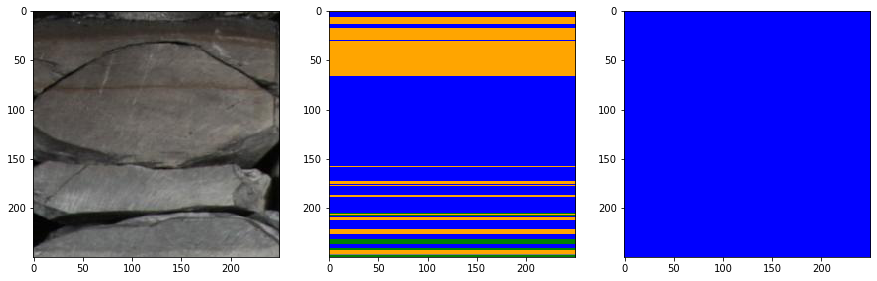

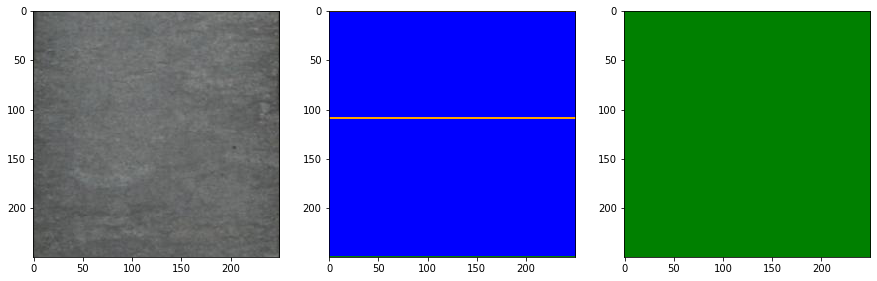

In [ ]:
for i in np.random.choice(len(images), 10, replace=False):
    plt.figure(figsize=(15, 15))
    plt.subplot(131)
    plt.imshow(images[i] / 255)
    plt.subplot(132)
    plt.imshow(predictions[i], vmin=0, vmax=len(mapping), norm=norm, cmap=cmap)
    plt.subplot(133)
    plt.imshow(targets[i], vmin=0, vmax=len(mapping), norm=norm, cmap=cmap)
    plt.show()